# Estimating COVID-19's $R_t$ in Real-Time

> Original code by Kevin Systrom - April 17 ( *translated into Julia by Hugh Murrell April 22*)

> Explanatory text is also by Kevin Systrom with comments by Hugh Murrell indented or in *italics*.

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, we don't yet use $R_t$ in this way. In fact, the only real-time measure I've seen has been for [Hong Kong](https://covid19.sph.hku.hk/dashboard). More importantly, it is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) granularity of $R_t$.

What follows is a solution to this problem at the US State level. It's a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R_t$ using a Bayesian approach. While this paper estimates a static $R$ value, here we introduce a process model with Gaussian noise to estimate a time-varying $R_t$.

If you have questions, comments, or improvments feel free to get in touch: [hello@systrom.com](mailto:hello@systrom.com). And if it's not entirely clear, I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so you can calibrate your beliefs as you wish. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere – internationally or to counties in the United States.

Additionally, a huge thanks to [Frank Dellaert](http://www.twitter.com/fdellaert/) who suggested the addition of the process and to [Adam Lerer](http://www.twitter.com/adamlerer/) who implemented the changes. Not only did I learn something new, it made the model much more responsive.

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __likelihood__ of seeing $k$ new cases given $R_t$ times ...
- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- divided by the probability of seeing this many cases in general.

This is for a single day. To make it iterative: every day that passes, we use yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. We will assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$, so $P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$, where $\sigma$ is a hyperparameter (see below on how we estimate $\sigma$). So on day one:

$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$

On day two:

$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$

etc.

### Choosing a Likelihood Function $P\left(k_t|R_t\right)$

A likelihood function function says how likely we are to see $k$ new cases, given a value of $R_t$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [1]:
using StatsBase, Distributions, Plots, DataFrames, CSV, Dates, HTTP, Impute;

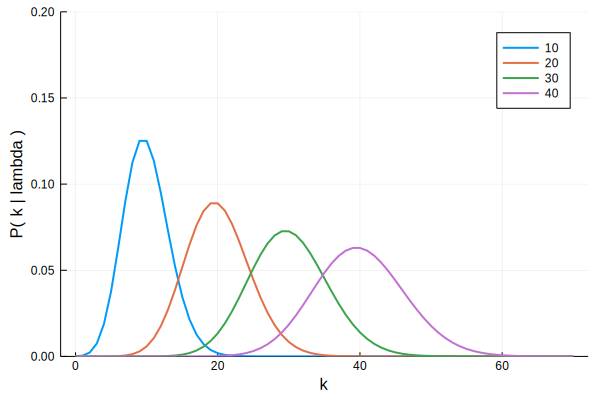

In [2]:
kGrid = 0:70
lambdas = [10 20 30 40]
pDist = [Poisson(lambda) for lambda in lambdas]
bPmf = [pdf.(pDist[i],kGrid) for i in 1:length(pDist)]
plot( kGrid, bPmf, lw=2, label=string.(lambdas), ylims=(0,0.2), 
    xlabel="k", ylabel="P( k | lambda )")

The Poisson distribution says that if you think you're going to have $\lambda$ cases per day, you'll probably get that many, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and we need to know what value of $\lambda$ is most likely. In order to do this, we fix $k$ in place while varying $\lambda$. __This is called the likelihood function.__

For example, imagine we observe $k=20$ new cases, and we want to know how likely each $\lambda$ is:

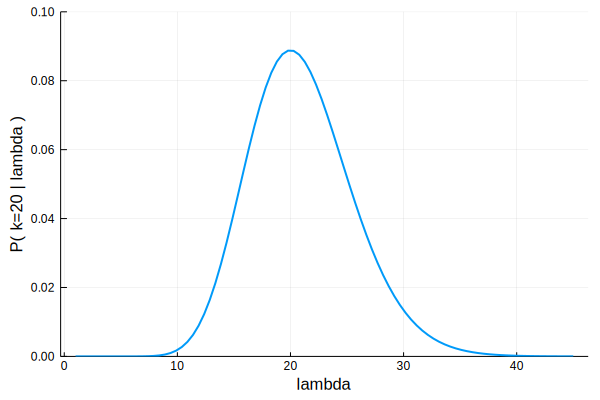

In [3]:
k=20
lambdas = collect(range(1.0,45.0,length=90))
pDist = [Poisson(lam) for lam in lambdas]
lk20 = [pdf.(pDist[i],k) for i in 1:length(pDist)]
plot( lambdas, lk20, lw=2, label="", ylims=(0,0.1), 
    xlabel="lambda", ylabel="P( k=20 | lambda )")

This says that if we see 20 cases, the most likely value of $\lambda$ is (not surprisingly) 20. But we're not certain: it's possible lambda was 21 or 17 and saw 20 new cases by chance alone. It also says that it's unlikely $\lambda$ was 40 and we saw 20.

Great. We have $P\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$ but we were looking for $P\left(k_t|R_t\right)$ which is parameterized by $R_t$. We need to know the relationship between $\lambda$ and $R_t$

### Connecting $\lambda$ and $R_t$

__The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the infectious period ([about 7 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)).

> Actually, in Bettencourt and Rebiero, the key insight is

$$ \lambda = I_t = I_{t-1}e^{\gamma(R_t-1)}$$

> where $I_t$ is the current *infectives* count. By *infectives* we mean the confirmed cases
> that can still transmit the virus. We assume that the virus is transmitable for up to
> $ \frac{1}{\gamma} $ days after confirmation.
>
> but the idea still works, we must just replace $k_t$ by $I_t$ where

$$ I_t = \Sigma_{s = t-\frac{1}{\gamma}+1}^t k_s $$ 

> in what follows (and in what appeared above).

Since we know every new case count (*or rather, since we know the number of infectives*) on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### Evaluating the Likelihood Function

To continue our example, let's imagine a sample of new *infective* counts $k$. What is the likelihood of different values of $R_t$ on each of those days?

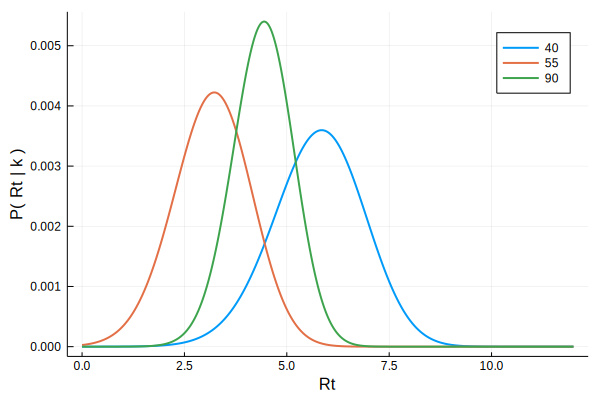

In [4]:
k = [20 40 55 90]

R_T_MAX = 12
r_t_range = collect(range(0, R_T_MAX, length=R_T_MAX*100+1))
INFECTIOUS_PERIOD = 7
GAMMA = 1/INFECTIOUS_PERIOD
lambdas = [ k[i-1] .* exp.(GAMMA .* (r_t_range .- 1)) for i in 2:length(k)]
pDist = [[Poisson(lam) for lam in lambdas[j]] for j in 1:length(lambdas) ]
lks = [ [pdf.(pDist[j-1][i],k[j]) for i in 1:length(pDist[j-1])] for j in 2:length(k)]
lks = hcat(lks...)
lks = lks ./ sum(lks, dims=1)
plot( r_t_range, lks, # line=:stem, marker=:xcross, c=:red, ms=6, msw=0, ylims=(0,0.1),
    lw=2, label=string.(k)[:,2:end],  xlabel="Rt", ylabel="P( Rt | k )")

You can see that each day we have a independent guesses for $R_t$. The goal is to combine the information we have about previous days with the current day. To do this, we use Bayes' theorem.

### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood without our Gaussian update, see later) to get the posteriors. Let's do that using the cumulative product of each successive day:

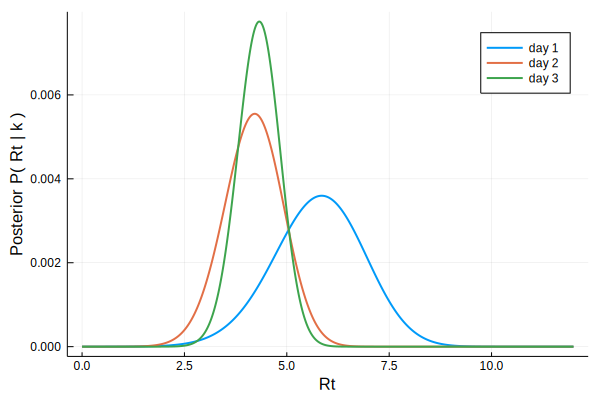

In [5]:
posteriors = cumprod(lks,dims=2)
posteriors = posteriors ./ sum(posteriors,dims=1)
plot( r_t_range, posteriors, lw=2, 
    label=reshape([ "day $i" for i in 1:size(posteriors)[2] ],(1,:)),  
    xlabel="Rt", ylabel="Posterior P( Rt | k )")

Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

In [6]:
mlrt_values = r_t_range[map(x->x[1],findmax(posteriors,dims=1)[2])[1,:]]

3-element Array{Float64,1}:
 5.85
 4.22
 4.33

We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:

In [7]:
function highest_density_interval(pmf, p=.9)
    fb = findmax(pmf,dims=1)[2][1]
    cs = cumsum(pmf, dims=1)
    first = [1, length(cs)]
    best = first
    for (i, value) in enumerate(cs)
        for (j, high_value) in enumerate(cs[i+1:end])
            if ( (high_value-value > p) && (j<best[2]-best[1]) )
                best = [i, i+j]
                break
            end
        end
    end
    if (best == first) 
        # println(" invoking fallback ... ", fb )
        best = [fb, fb]
    end
    return best
end        

highest_density_interval (generic function with 2 methods)

In [8]:
inds = [ highest_density_interval(posteriors[:,k]) for k in 1:size(posteriors)[2] ] 
low_high = [r_t_range[inds[k]] for k in 1:length(inds)]
lows = map(x->x[1],low_high)
highs = map(x->x[2],low_high)
df = DataFrame(day = 1:length(mlrt_values), mlrt = mlrt_values, low = lows, high = highs)

,day,mlrt,low,high
,Int64,Float64,Float64,Float64
1,1,5.85,3.89,7.55
2,2,4.22,2.96,5.33
3,3,4.33,3.42,5.12


Finally, we can plot both the most likely values for $R_t$ and the HDIs over time. This is the most useful representation as it shows how our beliefs change with every day.

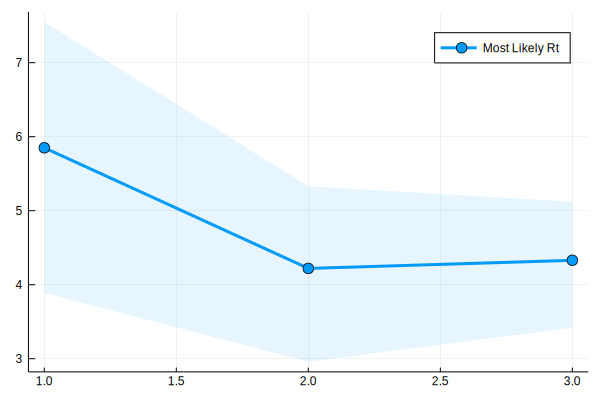

In [9]:
plot(df[:,:day], df[:,:mlrt], ribbon = (df[:,:mlrt]-df[:,:low],df[:,:high]-df[:,:mlrt]),
m=:circle, ms=6, fillalpha=0.1, lw = 3, label = "Most Likely Rt")

We can see that the most likely value of $R_t$ changes with time and the highest-density interval narrows as we become more sure of the true value of $R_t$ over time. Note that since we only had four days of history, I did not apply the process to this sample. Next, however, we'll turn to a real-world application where this process is necessary.

# Real-World Application to World Data

### Setup

We load World case data from OWID in csv format using this link:
https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/full_data.csv
and then we filter the data, country by country, removing sections with missing data or zero new case counts.

We need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we apply a filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

In [10]:
url="https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/full_data.csv"
full_data = CSV.read(IOBuffer(HTTP.get(url).body))
println("table read, size = ",size(full_data))
println("latest counts on ",maximum(full_data[:,:date]))

table read, size = (15828, 6)
latest counts on 2020-05-08


In [11]:
function moving_average(inf; alpha=0.5)
    vs = inf
    if length(vs) > 1
        ret = 
            # vcat( vs[1], [ alpha * vs[i] + (1 - alpha)*vs[i-1] for i = 2:length(vs) ] )
            vcat((vs[1]+2*vs[1])/3,
                   [sum(@view vs[i:(i+2)])/3 for i in 1:(length(vs)-(2))],
                    (2*vs[length(vs)]+vs[length(vs)])/3)
    else
        ret = vs
    end
    return ret
    return Int64.(round.(ret))
end

moving_average (generic function with 1 method)

In [12]:
function compute_infectives(new_cases) 
    if length(new_cases) >= INFECTIOUS_PERIOD
       infects = [sum(new_cases[i-INFECTIOUS_PERIOD+1:i])
                        for i in INFECTIOUS_PERIOD:length(new_cases) ] 
    else
        infects = []
    end
    return infects
end

compute_infectives (generic function with 1 method)

In [13]:
function region_of_interest(data)
    nz = copy(data[data[:,:date] .> Date(2020,2,23),:])
    ind = findmax(reverse(diff(nz[:,:date])))[2]
    if (ind != 1)
        nz = copy(nz[size(nz)[1]-ind+2:end,:])
    end
    nz[ismissing.(nz[:,:new_cases]),:new_cases] .= 0
    # if (minimum(nz[:,:new_cases])<0)
    #     nz[:,:new_cases] = abs.(nz[:,:new_cases])
    # end
    infectives = compute_infectives(nz[:,:new_cases])
    nz = nz[INFECTIOUS_PERIOD:end,:]
    nz[:,:infectives] = Float64.(infectives)
    allowmissing!(nz)
    # now insert missing dates and impute infectives for those dates
    if size(nz)[1] > 1
        dr = nz[1,:date]:Day(1):nz[end,:date]
        for d in dr
            if ! (d in nz[:,:date])
                push!(nz,vcat(d, nz[1,:location], [missing for i in 1:size(nz)[2]-2]))
            end
        end
        sort!(nz)
        nz[!,:infectives] = Impute.interp(nz[:,:infectives])
    end
    return nz[nz[:,:infectives].>0,:]
end        

region_of_interest (generic function with 1 method)

(49, 7)
min = -2461 max = 11536 latest data at 2020-05-08


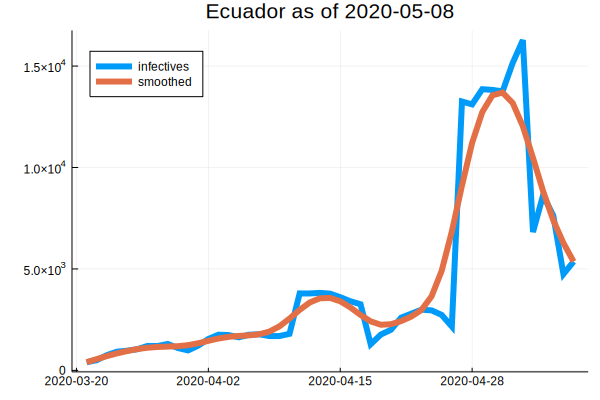

In [14]:
SMOOTHING_PASSES = 5
# full_data = CSV.read("data/full_data.csv")
countries = unique(full_data[:,:location])
country = "Ecuador"
country_data = full_data[full_data[:,:location].==country,:]
country_data_filtered = region_of_interest(country_data)
println(size(country_data_filtered))
end_date = country_data_filtered[:,:date][end]
println("min = ",minimum(country_data_filtered[:,:new_cases]), 
        " max = ",maximum(country_data_filtered[:,:new_cases]),
        " latest data at ",end_date)
smooth_infectives = country_data_filtered[:,:infectives]
for count in 1:SMOOTHING_PASSES
    smooth_infectives = moving_average(smooth_infectives) # gaussian_smoothing
end
plot(country_data_filtered[:,:date], 
    [country_data_filtered[:,:infectives], smooth_infectives], lw=6,
    legend=:topleft,
    labels=["infectives" "smoothed"],
    title="$country as of $end_date")

Putting all this into one function

In [15]:
function prepare_cases(full_data, country)
    country_data = full_data[full_data[:,:location].==country,:]
    country_data_filtered = region_of_interest(country_data)
    smooth_infectives = country_data_filtered[:,:infectives]
    for count in 1:SMOOTHING_PASSES
        smooth_infectives = moving_average(smooth_infectives) 
    end
    # zeros_at = findall(x->x==0,infectives)
    # if ( length(zeros_at) == 0 )
    #     start = 1
    # else
    #     start = maximum(zeros_at)+1
    # end
    sanity_check = minimum(country_data[:,:new_cases]) >= 0
    return (country_data_filtered[:,:date],country_data_filtered[:,:infectives], 
        smooth_infectives, sanity_check)
end

prepare_cases (generic function with 1 method)

sane = false


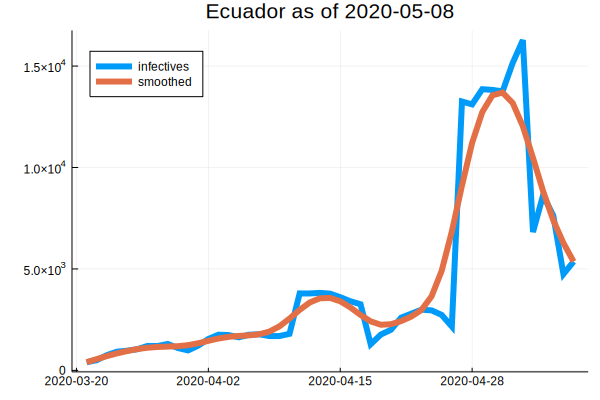

In [16]:
d,inf,sinf,sane = prepare_cases(full_data,country)
println("sane = ",sane)
end_date = d[end]
plot(d, [inf, sinf], lw=6,
    legend=:topleft,
    labels=["infectives" "smoothed"],
    title="$country as of $end_date")

In [17]:
println("sum of infectives = ",sum(inf),"   sum of smooth infectives = ",sum(sinf))

sum of infectives = 206194.0   sum of smooth infectives = 205206.89300411523


### Running the Algorithm

#### Choosing the Gaussian $\sigma$ for $P(R_t|R_{t-1})$

> Note: you can safely skip this section if you trust that we chose the right value of $\sigma$ for the process below. Otherwise, read on.

The original approach simply selects yesterday's posterior as today's prior. While intuitive, doing so doesn't allow for our belief that the value of $R_t$ has likely changed from yesterday. To allow for that change, we apply Gaussian noise to the prior distribution with some standard deviation $\sigma$. The higher $\sigma$ the more noise and the more we will expect the value of $R_t$ to drift each day. Interestingly, applying noise on noise iteratively means that there will be a natural decay of distant posteriors. This approach has a similar effect of windowing, but is more robust and doesn't arbitrarily forget posteriors after a certain time like my previous approach. Specifically, windowing computed a fixed $R_t$ at each time $t$ that explained the surrounding $w$ days of cases, while the new approach computes a series of $R_t$ values that explains all the cases, assuming that $R_t$ fluctuates by about $\sigma$ each day.

However, there's still an arbitrary choice: what should $\sigma$ be? Adam Lerer pointed out that we can use the process of maximum likelihood to inform our choice. Here's how it works:

Maximum likelihood says that we'd like to choose a $\sigma$ that maximizes the likelihood of seeing our data $k$: $P(k|\sigma)$. Since $\sigma$ is a fixed value, let's leave it out of the notation, so we're trying to maximize $P(k)$ over all choices of $\sigma$.

Since $P(k)=P(k_0,k_1,\ldots,k_t)=P(k_0)P(k_1)\ldots P(k_t)$ we need to define $P(k_t)$. It turns out this is the denominator of Bayes rule:

$$P(R_t|k_t) = \frac{P(k_t|R_t)P(R_t)}{P(k_t)}$$

To calculate it, we notice that the numerator is actually just the joint distribution of $k$ and $R$:

$$ P(k_t,R_t) =  P(k_t|R_t)P(R_t) $$

We can marginalize the distribution over $R_t$ to get $P(k_t)$:

$$ P(k_t) = \sum_{R_{t}}{P(k_t|R_t)P(R_t)} $$

So, if we sum the distribution of the numerator over all values of $R_t$, we get $P(k_t)$. And since we're calculating that anyway as we're calculating the posterior, we'll just keep track of it separately.

Since we're looking for the value of $\sigma$ that maximizes $P(k)$ overall, we actually want to maximize: 

$$\prod_{t,i}{p(k_{ti})}$$

where $t$ are all times and $i$ is each state.

Since we're multiplying lots of tiny probabilities together, it can be easier (and less error-prone) to take the $\log$ of the values and add them together. Remember that $\log{ab}=\log{a}+\log{b}$. And since logarithms are monotonically increasing, maximizing the sum of the $\log$ of the probabilities is the same as maximizing the product of the non-logarithmic probabilities for any choice of $\sigma$.

### Function for Calculating the Posteriors

To calculate the posteriors we follow these steps:
1. Calculate $\lambda$ - the expected arrival rate for every day's poisson process
2. Calculate each day's likelihood distribution over all possible values of $R_t$
3. Calculate the process matrix based on the value of $\sigma$ we discussed above
4. Calculate our initial prior because our first day does not have a previous day from which to take the posterior
  - Based on [info from the cdc](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article) we will choose a Gamma with mean 7.
5. Loop from day 1 to the end, doing the following:
  - Calculate the prior by applying the Gaussian to yesterday's prior.
  - Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
  - Divide by the probability of the data (also Bayes' rule)

In [18]:
pdf.(Poisson(8.003),7)

0.1395341281547606

In [19]:
function get_posteriors(inf, sigma=0.23)
    sr = inf # Int64.(floor.(inf))
    # (1) Calculate Lambda
    R_T_MAX = 12
    r_t_range = collect(range(0, R_T_MAX, length=R_T_MAX*100+1))
    GAMMA = 1/INFECTIOUS_PERIOD
    lambdas = [ sr[i-1] .* exp.(GAMMA .* (r_t_range .- 1)) for i in 2:length(sr)]
    lambdas = hcat(lambdas...)

    # (2) Calculate each day's likelihood
    pDist = [[Poisson(lam) for lam in lambdas[:,j]] for j in 1:size(lambdas)[2] ]
    lks = [ [pdf.(pDist[j-1][i],Int64(floor(sr[j]))) for i in 1:length(pDist[j-1])] for j in 2:length(sr)]
    lks = hcat(lks...)
    likelihoods = lks ./ sum(lks, dims=1)
    
     # (3) Create the Gaussian Matrix
    nDist = [ Normal(rt,sigma) for rt in r_t_range ]
    process_matrix = [ [pdf.(nDist[j],r_t_range[i]) for i in 1:length(r_t_range)] 
        for j in 1:length(r_t_range)]
    process_matrix = hcat(process_matrix...)
    
    # (3a) Normalize all rows to sum to 1
    process_matrix = process_matrix ./ sum(process_matrix, dims=2)
    
    # process_matrix = I   # if you want current prior = previous posterior
    
    # (4) Calculate the initial prior
    guess0 = 2+log(sr[2]/sr[1])/GAMMA
    if guess0 < 1 
        guess0 = 1
    end
    # println(guess0)
    prior0 = [ pdf.(Gamma(guess0),rt) for rt in r_t_range ]
    prior0 = prior0 ./ sum(prior0)
    
    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = DataFrame( [ Real for i in 1:length(sr) ], 
        [ Symbol.("D$i") for i in 1:length(sr) ], length(r_t_range) )
    days = names(posteriors)
    # posteriors[:,:rts] = r_t_range
    posteriors[:,:D1] = prior0
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0
    
       # (5) Iteratively apply Bayes' rule
    nd = length(days)
    # println("nd=$nd")
    for (previous_day, current_day) in zip(1:nd-1, 2:nd)

        #(5a) Calculate the new prior
        current_prior =   process_matrix * posteriors[:,Symbol("D$previous_day")] # 
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[:,current_day-1] .* current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[:,Symbol("D$current_day")] = numerator./denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += log(denominator)
        
    end
    
    return (posteriors, r_t_range, log_likelihood)
    
end

get_posteriors (generic function with 2 methods)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

In [20]:
[(sigma, get_posteriors(sinf,sigma)[3]) for sigma in 0.2:0.01:0.3]

11-element Array{Tuple{Float64,Float64},1}:
 (0.2, -253.09250019157255) 
 (0.21, -250.07095704057815)
 (0.22, -247.54167717839755)
 (0.23, -245.4265371250382) 
 (0.24, -243.6616835813593) 
 (0.25, -242.19455421162763)
 (0.26, -240.98159756843594)
 (0.27, -239.98650936574833)
 (0.28, -239.17885545759378)
 (0.29, -238.53298784622825)
 (0.3, -238.0271849763149)  

ll=-245.4265371250382
(1201, 49)

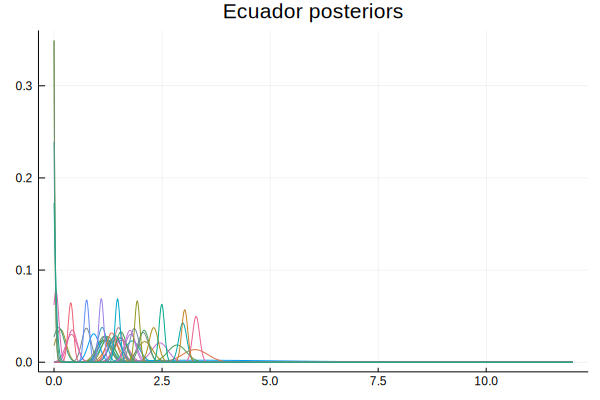

In [21]:
(posteriors, rts, log_likelihood) = get_posteriors(sinf)
println("ll=",log_likelihood)
print(size(posteriors))
plot(rts,Array(posteriors),label=nothing,title=country*" posteriors")

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

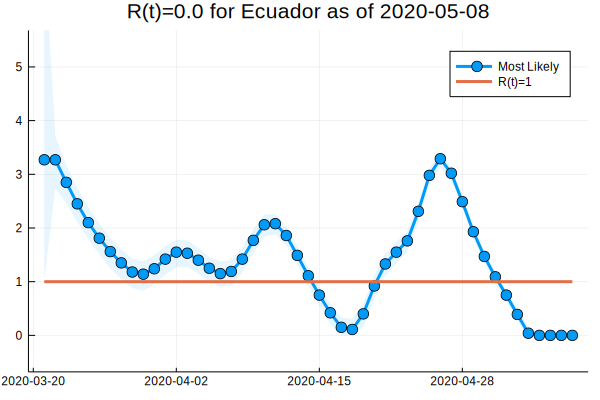

In [22]:
mlrt_values = rts[map(x->x[1],findmax(Array(posteriors),dims=1)[2])[1,:]]
inds = [ highest_density_interval(posteriors[:,k]) for k in 1:size(posteriors)[2] ] 
low_high = [r_t_range[inds[k]] for k in 1:length(inds)]
lows = map(x->x[1],low_high)
highs = map(x->x[2],low_high)
df = DataFrame(date = country_data_filtered[:,:date], mlrt = mlrt_values, low = lows, high = highs)
# df = df[2:end,:]
mlrt_score = round(sum(mlrt_values[end:end]),digits=1)
fig = plot(df[:,:date], df[:,:mlrt],
        ribbon = (df[:,:mlrt]-df[:,:low],df[:,:high]-df[:,:mlrt]),
        fillalpha=0.1, lw = 3, label = "Most Likely",
        m=:circle, ms=6, ylimits=[-0.5,5.5],
        title= "R(t)=$mlrt_score for $country as of $end_date")
plot!(df[:,:date], ones(size(df)[1]),lw=3,label="R(t)=1")
savefig("plots/Rt_$country")
fig

#### Now lets try and produce current most likely Rt for each country with enough case data

In [41]:
output_url = "../../HughMurrell.github.io/CoVmodel/RtLive/"

"../../HughMurrell.github.io/CoVmodel/RtLive/"

In [43]:
countries = unique(full_data[:,:location])
df = DataFrame(country=String[], start_date=Date[],end_date=Date[],
                    mlrt=Float64[],low=Float64[],high=Float64[],irat=Float64[],rank=Float64[])
for country in countries
    dates,infectives,smooth_infectives,sane = prepare_cases(full_data,country)
    if ( ! sane || length(infectives)<10 || maximum(infectives) < 400)
        println("skipping $country ... sanity check is $sane")
    else
        println("processing $country ...")
        start_date = dates[1]  
        end_date = dates[end]
        # calculate ratio of last I(t) to maximum of all I(t)s
        irat = round(infectives[end]/maximum(infectives),digits=2)
        fig = plot(dates, [infectives, smooth_infectives], lw=6,
            legend=:topleft,
            label=[ "infectious" "smoothed" ],
            title="$country,  I(t)/I(max) = $irat at $end_date")
        savefig(output_url*"plots/Inf_$country")
        (posteriors, rts, log_likelihood) = get_posteriors(smooth_infectives)
        mlrt_values = rts[map(x->x[1],findmax(Array(posteriors),dims=1)[2])[1,:]]
        last_week = mlrt_values[end-6:end]
        if maximum(last_week)-minimum(last_week) > 2
            println("something fishy, skipping $country anyway ...")
        else
            inds = [ highest_density_interval(posteriors[:,k]) for k in 1:size(posteriors)[2] ] 
            low_high = [rts[inds[k]] for k in 1:length(inds)]
            lows = map(x->x[1],low_high)
            highs = map(x->x[2],low_high)
            # make an Rt plot for this country
            mlrt_score = round(sum(mlrt_values[end:end]),digits=2)
            cdf = DataFrame(date = dates, mlrt = mlrt_values, 
                low = lows, high = highs)
            fig = plot(cdf[:,:date], cdf[:,:mlrt], 
                ribbon = (cdf[:,:mlrt]-cdf[:,:low],cdf[:,:high]-cdf[:,:mlrt]),
                fillalpha=0.1, lw = 3, label = "Most Likely",
                m=:circle, ms=6, ylimits=[-0.5,5.5],
                title="$country, R(t) = $mlrt_score at $end_date")
            plot!(cdf[:,:date], ones(size(cdf)[1]),lw=3,label="R(t)=1")
            savefig(output_url*"plots/Rt_$country")
            # now save last mlrt, low, high, irat and rank
            rank = round(mlrt_score * irat, digits=2)
            push!(df,
                [country start_date end_date mlrt_score cdf[end, :low] cdf[end, :high] irat rank]
            )
        end
    end
end
df

processing Afghanistan ...
skipping Albania ... sanity check is true
processing Algeria ...
skipping Andorra ... sanity check is true
skipping Angola ... sanity check is true
skipping Anguilla ... sanity check is true
skipping Antigua and Barbuda ... sanity check is true
processing Argentina ...
processing Armenia ...
skipping Aruba ... sanity check is true
processing Australia ...
processing Austria ...
processing Azerbaijan ...
skipping Bahamas ... sanity check is true
processing Bahrain ...
processing Bangladesh ...
skipping Barbados ... sanity check is true
processing Belarus ...
processing Belgium ...
skipping Belize ... sanity check is true
skipping Benin ... sanity check is true
skipping Bermuda ... sanity check is true
skipping Bhutan ... sanity check is true
processing Bolivia ...
skipping Bonaire Sint Eustatius and Saba ... sanity check is true
skipping Bosnia and Herzegovina ... sanity check is true
skipping Botswana ... sanity check is true
processing Brazil ...
skipping Br

,country,start_date,end_date,mlrt,low,high,irat
,String,Date,Date,Float64,Float64,Float64,Float64
1,Afghanistan,2020-03-20,2020-05-08,1.23,0.94,1.46,0.96
2,Algeria,2020-03-19,2020-05-08,1.1,0.8,1.35,0.99
3,Argentina,2020-03-20,2020-05-08,1.04,0.71,1.31,0.86
4,Armenia,2020-03-19,2020-05-08,1.5,1.16,1.79,0.96
5,Australia,2020-03-01,2020-05-08,1.41,0.8,1.96,0.05
6,Austria,2020-03-01,2020-05-08,0.4,0.0,0.8,0.05
7,Azerbaijan,2020-03-19,2020-05-08,1.51,1.07,1.88,0.73
8,Bahrain,2020-03-11,2020-05-08,1.71,1.4,1.96,1.0
9,Bangladesh,2020-03-23,2020-05-08,1.26,1.09,1.4,1.0


In [44]:
dft = df
sort!(dft,:country)
CSV.write(output_url*"data/ranking_alpha.csv",dft)
sort!(dft,:rank)
CSV.write(output_url*"data/ranking_rank.csv",dft)

"../../HughMurrell.github.io/CoVmodel/RtLive/data/ranking_rank.csv"

In [45]:
first(dft,6)

,country,start_date,end_date,mlrt,low,high,irat,rank
,String,Date,Date,Float64,Float64,Float64,Float64,Float64
1,China,2020-03-01,2020-05-08,0.0,0.0,0.78,0.01,0.0
2,Croatia,2020-03-18,2020-05-08,0.03,0.0,0.88,0.09,0.0
3,Djibouti,2020-03-25,2020-05-08,0.0,0.0,0.72,0.07,0.0
4,Estonia,2020-03-18,2020-05-08,0.0,0.0,0.73,0.07,0.0
5,Iceland,2020-03-01,2020-05-08,0.0,0.0,1.13,0.01,0.0
6,Israel,2020-03-13,2020-05-08,0.0,0.0,0.35,0.1,0.0


In [46]:
maximum(dft[:,:end_date])

2020-05-08

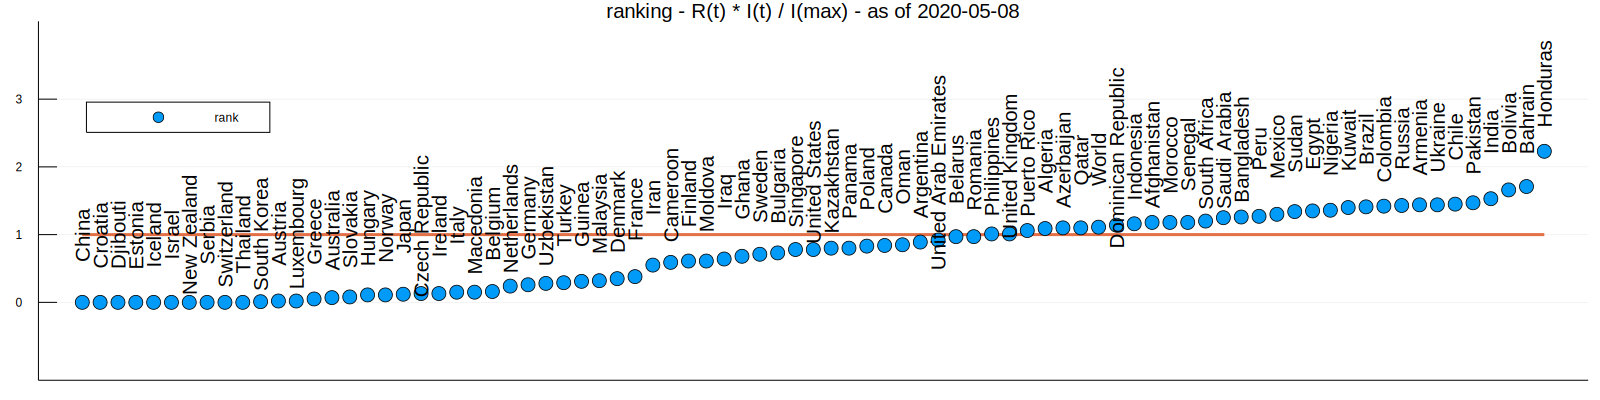

In [47]:
Plots.Font("sans-serif", 10, :hcenter, :center, 0.0, RGB(0.0,0.0,0.0))
myfont = text("").font
myfont.rotation = 90
end_date = maximum(dft[:,:end_date])
fig = plot()
# fig = scatter( (dft[:,:high]+dft[:,:low])/2, 
#     yerror = (dft[:,:high]-dft[:,:low])/2, c=3,
#     m = :circle, ms = 0, markerstrokewidth = 2, label="")
plot!(ones(size(dft)[1]),label="",c=2, lw=3,    
    title="ranking - R(t) * I(t) / I(max) - as of $end_date")
scatter!(dft[:,:rank],markershape=:circle,   
    markersize = 8, c=1, 
    ylims=[-1, 4], yticks = [0.0, 1.0, 2.0, 3.0], xticks = [],
    # series_annotations=text.(dft[:,:country], :middle, 6, :hcenter, :vcenter),
    size=(1600,400),
    label="rank", legend=:topleft)
for j in 1:size(dft)[1]
    annotate!(j,dft[:,:rank][j]+1, dft[:,:country][j], myfont)
end
savefig("plots/ranking")
fig

## A Simulated outbreak

In [29]:
country = "Simulated"

"Simulated"

In [30]:
using Distributions, Plots
function sim_SIR_withRt(;R0 = 2, y = 1/7, pop = 1000000, init = 1000, upper = 70)
  NC,Sv,Iv,Rv,Cv,Rtv = zeros(Int,upper),zeros(Int,upper),zeros(Int,upper),
    zeros(Int,upper),zeros(Int,upper),zeros(Float64,upper)
  b = R0 * y
  S = pop
  I = init
  C = I
  R = 0
  for i in 1:upper
       # b = 0.98 * b
      new_cases = min(rand(Poisson(b*S*I/(S+I))),S)
      I += new_cases
      S -= new_cases
      recoveries = min(rand(Poisson(y*I)),I)
      I -= recoveries
      R += recoveries
       
      C += new_cases  
      Rt = R0*(S/(S+I)) 
       
      NC[i],Sv[i],Iv[i],Rv[i],Cv[i],Rtv[i] = new_cases,S,I,R,C,Rt
  end
  return NC,Sv,Iv,Rv,Cv,Rtv
end

sim_SIR_withRt (generic function with 1 method)

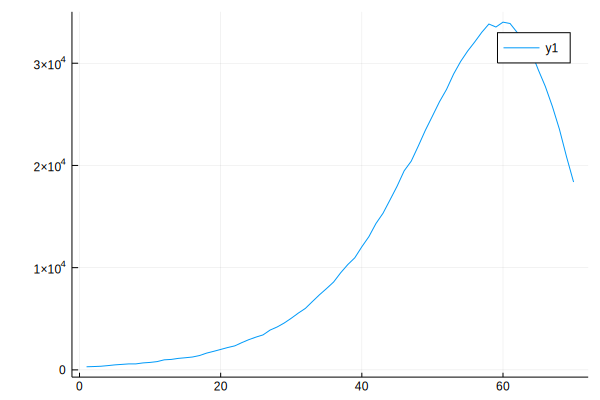

In [31]:
trial = sim_SIR_withRt();
new_cases = trial[1]
plot([new_cases])

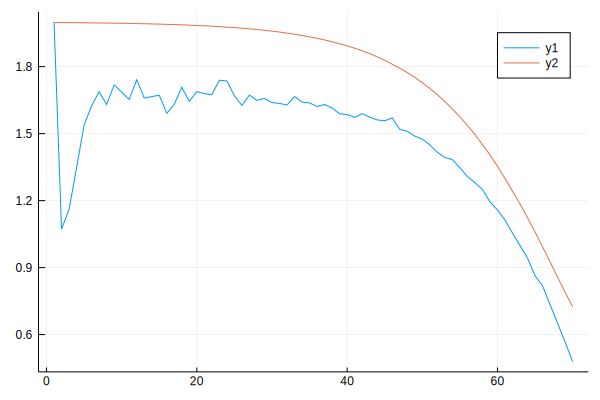

In [32]:
infectives = [sum(new_cases[max(1,i-7+1):i])+max(7-i,0)*new_cases[1]
        for i in 1:length(new_cases) ] 
# recovered = cumsum(new_cases)
# infectives = trial[3]
Rt_estimate = vcat( [2], 
    [(1 + 7 * log(infectives[i+1]/infectives[i])) 
        for i in 1:length(new_cases)-1 ] )    
# Rt_estimate = (2.0 .* trial[2])./(trial[2].+infectives)
plot([ Rt_estimate, trial[6] ])

In [33]:
length(infectives)

70

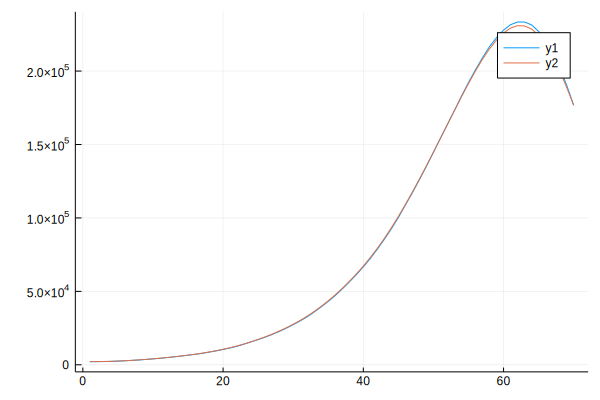

In [34]:
smooth_infectives = copy(infectives)
    for count in 1:4
        smooth_infectives = copy(moving_average(smooth_infectives))
    end
plot([infectives,smooth_infectives])

(70,)


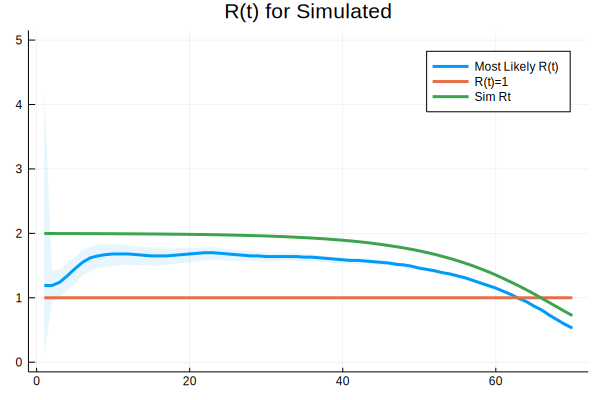

In [35]:
(posteriors, rts, log_likelihood) = get_posteriors(smooth_infectives)
mlrt_values = rts[map(x->x[1],findmax(Array(posteriors),dims=1)[2])[1,:]] 
println(size(mlrt_values))
# adjusted_values = (log.(mlrt_values)./GAMMA).+1
inds = [ highest_density_interval(posteriors[:,k]) for k in 1:size(posteriors)[2] ] 
low_high = [r_t_range[inds[k]] for k in 1:length(inds)]
lows = map(x->x[1],low_high) 
highs = map(x->x[2],low_high) 
df = DataFrame(day = 1:length(mlrt_values), mlrt = mlrt_values, low = lows, high = highs)
fig = plot(df[:,:day], df[:,:mlrt], ribbon = (df[:,:mlrt]-df[:,:low],df[:,:high]-df[:,:mlrt]),
fillalpha=0.1, lw = 3, label = "Most Likely R(t)")
plot!(ones(size(df)[1]),lw=3,label="R(t)=1",
title= "R(t) for $country")
plot!(trial[6],lw=3,label="Sim Rt",ylimit=[0,5])
# plot!(adjusted_values,lw=3,label="Adjusted")
savefig("plots/Rt_$country")
fig

In [48]:
function compute_smooth_infectives(inf)
    smooth_inf = inf
    for count in 1:SMOOTHING_PASSES
        smooth_inf = moving_average(smooth_inf) # gaussian_smoothing
    end
    return smooth_inf
end

compute_smooth_infectives (generic function with 1 method)

In [49]:
output_url = "../../HughMurrell.github.io/CoVmodel/RtLiveZA/"
url="https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
data = CSV.read(IOBuffer(HTTP.get(url).body),
            types=[String, String, Float64, Float64, Float64, Float64, Float64, 
                    Float64, Float64, Float64, Float64, Float64, Float64, String])
date_format = DateFormat("dd-mm-yyyy")
data[!,:date] = Date.(data[:,:date],date_format)
data = data[:,[:date, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :total]]
dr = data[1,:date]:Day(1):data[end,:date]
for d in dr
    if ! (d in data[:,:date])
        push!(data,vcat(d, [missing for i in 1:size(data)[2]-2], 0))
    end
end
sort!(data)
latest_date = maximum(data[:,:date])
regions=names(data)[2:end]
fig_inf = plot(legendtitle="latest count",legend=:topleft,ylabel="infectives",
    title="tracking infectives in South Africa \n as of $latest_date")
fig_rts = plot(legendtitle="latest R",legend=:bottomleft,ylabel="R(t)", ylimits = [-1,3],
    title="tracking R(t) in South Africa \n as of $latest_date")
for region in regions
    cases = Impute.interp(data[:,region])   # can impute on total cases (not on new-cases)
    infectives = [ cases[i]-cases[i-6] for i in 7:length(cases) ]
    dates = data[7:end,:date]
    if(maximum(infectives)<100)
        println("skipping ... ",region)
    else
        println("processing ... ",region)
        smooth_inf = compute_smooth_infectives(infectives)
        dates = dates[smooth_inf[:] .> 0]
        infectives = infectives[smooth_inf[:] .> 0]
        smooth_inf = smooth_inf[smooth_inf .> 0]
        (posteriors, rts, log_likelihood) = get_posteriors(smooth_inf)
        mlrt_values = rts[map(x->x[1],findmax(Array(posteriors),dims=1)[2])[1,:]] 
        inds = [ highest_density_interval(posteriors[:,k]) for k in 1:size(posteriors)[2] ] 
        low_high = [r_t_range[inds[k]] for k in 1:length(inds)]
        lows = map(x->x[1],low_high) 
        highs = map(x->x[2],low_high) 
        score = round(mlrt_values[end],digits=1)
        if (region == :total)
            lab = "ZA-$score"
        else
            lab = "$region-$score"
        end
        plot!(fig_rts, dates, mlrt_values, lw=6,m=:circle,label=lab)
        count = Int64(round(infectives[end],digits=0))
        if (region == :total)
            lab = "ZA-$count"
        else
            lab = "$region-$count"
        end
        plot!(fig_inf, dates, smooth_inf,lw=6,m=:circle,label=lab)
        # plot!(fig_inf, dates, infectives,lw=6,m=:circle,label=String(region))
    end
end
savefig(fig_rts,output_url*"plots/RtLiveZA")
savefig(fig_inf,output_url*"plots/InfLiveZA")

processing ... EC
skipping ... FS
processing ... GP
processing ... KZN
skipping ... LP
skipping ... MP
skipping ... NC
skipping ... NW
processing ... WC
processing ... total


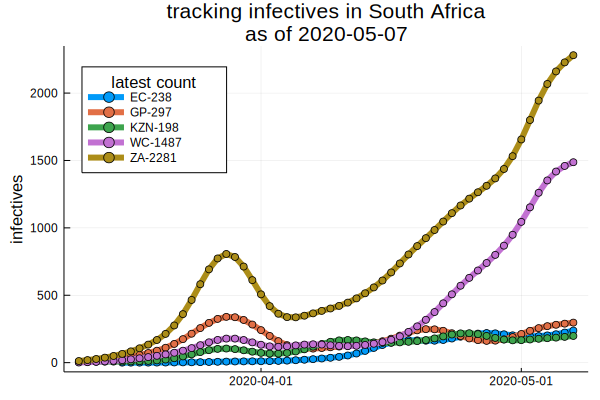

In [50]:
fig_inf

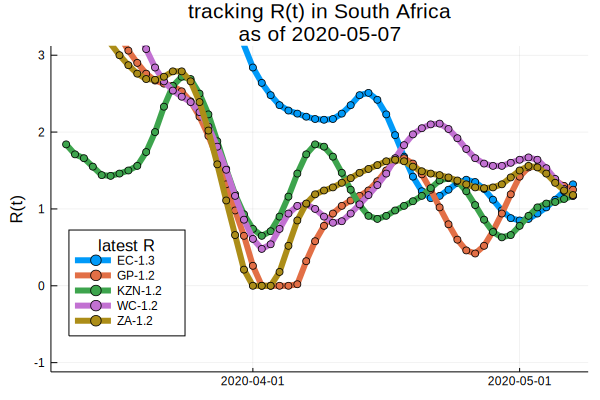

In [51]:
fig_rts